In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi


import torch
print(torch.cuda.is_available())


import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


Tue Jun 11 17:09:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

** *italicized text*Step 1. Define purpose of the ML project.**
This project aims to predict fraudulent transactions using synthetic financial datasets sourced from Kaggle. Correctly identifying whether a transaction is fraudulent is extremely important as fraudsters aim to empty out the victim's bank account through methods that involve transferring and then immediately cashing out. If fraud occurs and suspicious transactions are not stopped, it can result in life-changing scenarios. Correctly identifying fraudulent transactions will improve the customer's perception of the bank. This project will be an end-to-end pipeline and uploaded to the author's Github.

**List of Attributes**

Attribute	Description
step:	Maps a unit of time in the real world. In this case, 1 step is 1 hour of time. Total steps 744 (30 days simulation).


type	:CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.


amount:	Amount of the transaction in local currency.


nameOrig	:Customer who started the transaction.


oldbalanceOrg	:Initial balance before the transaction.


newbalanceOrig:	New balance after the transaction.


nameDest:	Customer who is the recipient of the transaction.


oldbalanceDest:	Initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).


newbalanceDest:	New balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).


isFraud	:Transactions made by the fraudulent agents inside the simulation. Aiming to profit by taking control of customers' accounts and trying to empty the funds by transferring to another account and then cashing out of the system.


isFlaggedFraud:	Controls massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.


Information provided by Kaggle.

Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.

**Step 2. Obtain the Database for the Analysis**

In [ ]:

import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/1-Simran/Fraud_dataset.csv'  # Change to your dataset path
df = pd.read_csv(file_path)
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

**Observations:**
As stated on Kaggle, there is no information on 'oldbalanceDest' and 'newbalanceDest' for customers whose 'nameDest' starts with 'M'.
According to Kaggle, 'isFraud' is likely when a 'TRANSFER' is followed by a 'CASHOUT' in the 'type' column. The 'amount' is highly likely to be the same between the two transaction types.
As indicated on Kaggle, 'isFlaggedFraud' is likely to occur when transferring more than 200,000 in a single transaction.
A large amount of synthetic data was scaled down to 1/4 of the original dataset.

**Step 3. Explore, clean & preprocess the data**
This dataset is a rare source, as most financial data have privacy issues and are usually transformed by PCA to obscure the actual data. Having the data in its raw form makes exploration more interesting and engaging. More feature engineering can be applied here.

In [ ]:
pd.set_option('display.max_columns', None,
              'display.float_format', lambda x: '%.2f' % x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


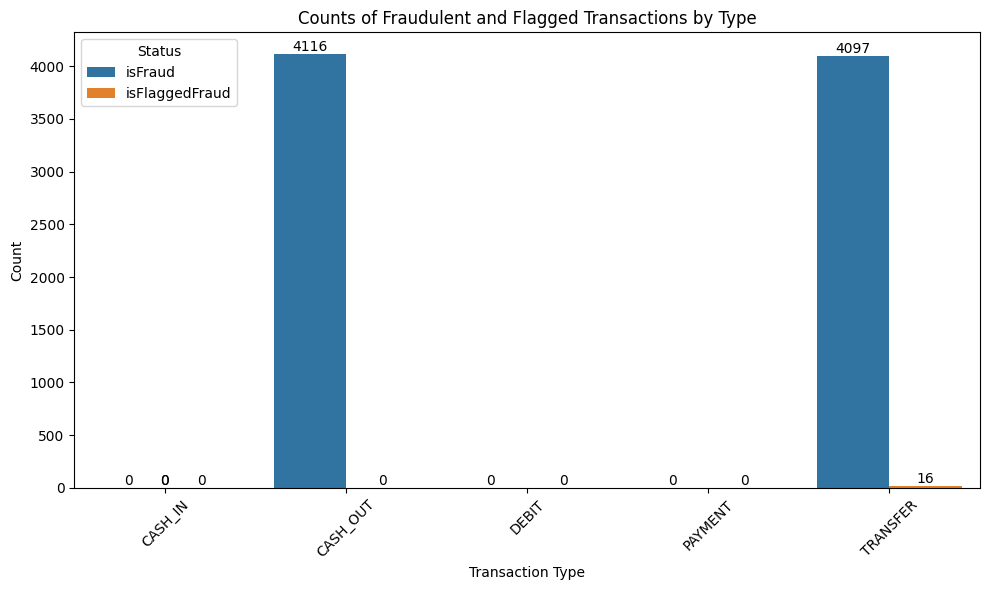

In [ ]:
#Importing necessary library
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

agg_df = df.groupby('type').agg({'isFraud': 'sum', 'isFlaggedFraud': 'sum'}).reset_index()

# Melting the DataFrame for easier plotting
melted_df = pd.melt(agg_df, id_vars=['type'], value_vars=['isFraud', 'isFlaggedFraud'],
                    var_name='Fraud Status', value_name='Count')

# Plotting with seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=melted_df, x='type', y='Count', hue='Fraud Status')

# Adding annotations to each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     size=10, xytext = (0, 5),
                     textcoords = 'offset points')

plt.title('Counts of Fraudulent and Flagged Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Status')

plt.tight_layout()
plt.show()

**Observations:**


1. No obvious outliers.


2. Three columns have 'object' as their data type.


3. The 'type' column, containing 'CASH_OUT' and 'TRANSFER', includes fraudulent transactions.


**Decisions:**


1. Use OneHotEncoder to categorize the 'type' column, as it is more reliable since it maintains the categories on which it was trained

In [ ]:
df['type'].value_counts(), df['nameOrig'].value_counts(), df['nameDest'].value_counts()

(type
 CASH_OUT    2237500
 PAYMENT     2151495
 CASH_IN     1399284
 TRANSFER     532909
 DEBIT         41432
 Name: count, dtype: int64,
 nameOrig
 C1902386530    3
 C363736674     3
 C545315117     3
 C724452879     3
 C1784010646    3
               ..
 C98968405      1
 C720209255     1
 C1567523029    1
 C644777639     1
 C1280323807    1
 Name: count, Length: 6353307, dtype: int64,
 nameDest
 C1286084959    113
 C985934102     109
 C665576141     105
 C2083562754    102
 C248609774     101
               ... 
 M1470027725      1
 M1330329251      1
 M1784358659      1
 M2081431099      1
 C2080388513      1
 Name: count, Length: 2722362, dtype: int64)

In [ ]:
frequentDest = df[(df['nameDest'] == 'C1286084959') |
                          (df['nameDest'] == 'C985934102') |
                          (df['nameDest'] == 'C665576141')]

frequentDest['isFraud'].value_counts()

isFraud
0    327
Name: count, dtype: int64

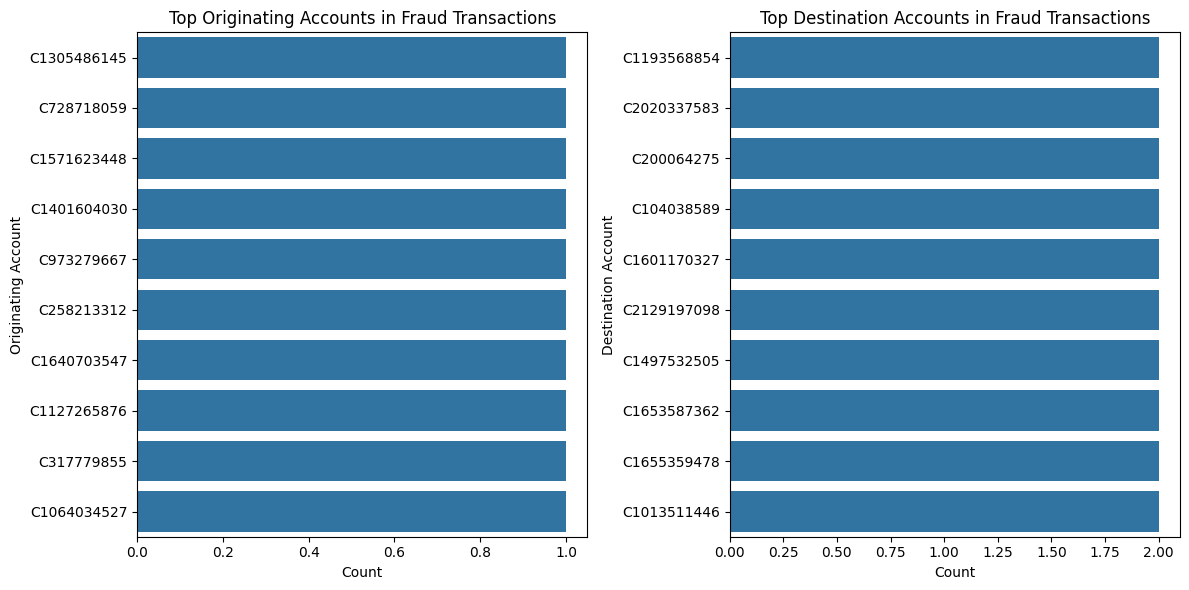

In [ ]:
fraud_df = df[df['isFraud'] == 1]
top_n = 10

# Get top N origins and destinations in fraud cases
top_origins = fraud_df['nameOrig'].value_counts().nlargest(top_n).index
top_destinations = fraud_df['nameDest'].value_counts().nlargest(top_n).index

# Filter data to include only top N origins and destinations
filtered_df = fraud_df[(fraud_df['nameOrig'].isin(top_origins)) | (fraud_df['nameDest'].isin(top_destinations))]

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=filtered_df, y='nameOrig', order=filtered_df['nameOrig'].value_counts().iloc[:top_n].index)
plt.title('Top Originating Accounts in Fraud Transactions')
plt.xlabel('Count')
plt.ylabel('Originating Account')

plt.subplot(1, 2, 2)
sns.countplot(data=filtered_df, y='nameDest', order=filtered_df['nameDest'].value_counts().iloc[:top_n].index)
plt.title('Top Destination Accounts in Fraud Transactions')
plt.xlabel('Count')
plt.ylabel('Destination Account')

plt.tight_layout()
plt.show()

In [ ]:
starts_with_m = fraud_df[(fraud_df['nameOrig'].str.startswith('M')) |
                         (fraud_df['nameDest'].str.startswith('M'))]

print(f"The total number of frauds with Merchants are {starts_with_m.shape[0]}",
      f"out of {len(fraud_df)}")

The total number of frauds with Merchants are 0 out of 8213


In [ ]:
starts_with_c = fraud_df[(fraud_df['nameOrig'].str.startswith('C')) |
                         (fraud_df['nameDest'].str.startswith('C'))]

print(f"The total number of frauds with customer are {starts_with_c.shape[0]}",
     f"out of {len(fraud_df)}")

The total number of frauds with customer are 8213 out of 8213


**Observations:**

1. Frequent transfers to the same destination do not necessarily indicate fraudulent accounts. The numbers at the end of the names mean nothing significant.


2. Merchants do not have any frauds; only customers are identified as frauds.



3. Since fraudsters do not stick with one name, we can ignore the numerical values in the 'name' columns.



**Decisions:**


2. Remap names with 'Merchant' as '0' and 'Customer' as '1'.

In [ ]:
print(f"'isFraud' Target class represents \n"
      f"{df['isFraud'].value_counts(normalize=True) * 100} %\n")

print(f"'isFlaggedFraud' Target class represents \n"
      f"{df['isFlaggedFraud'].value_counts(normalize=True) * 100} %")

'isFraud' Target class represents 
isFraud
0   99.87
1    0.13
Name: proportion, dtype: float64 %

'isFlaggedFraud' Target class represents 
isFlaggedFraud
0   100.00
1     0.00
Name: proportion, dtype: float64 %


**Observation:**

1. The dataset is imbalanced, which is expected as fraud cases are usually in the minority.


**Decision:**

3. To use customized stratified sampling to undersample the data that is not of class interest.

In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**Observation:**

1. No missing values.


Explore fraudulent transactions type 'isFlaggedFraud'

In [ ]:
# Expanding the list that's flagged as fraud for potentially suspicious transaction before/after
def expansion(check_df, x=0):

    check_list = check_df.index.tolist()
    expand_list = []

    for i in check_list:
        expand_list.append(i)
        if i + 1 < len(check_df):
            expand_list.append(i + 1)
        if x == 1 and i - 1 >= 0:
            expand_list.append(i - 1)

    full_check_fraud = pd.DataFrame(expand_list, columns=['Index'])
    full_check_fraud = full_check_fraud.drop_duplicates().sort_values(by='Index')
    full_check_fraud = full_check_fraud['Index'].tolist()
    full_check_fraud = df.loc[full_check_fraud]

    return full_check_fraud

In [ ]:
flagged_df = df[df['isFlaggedFraud'] == 1]
print(f'Total number of flagged transactions are {len(flagged_df)}')
flagged_df

Total number of flagged transactions are 16


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.00,0.00,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.00,0.00,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.00,0.00,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.00,0.00,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.00,0.00,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.00,0.00,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.00,0.00,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.00,0.00,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.00,0.00,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.00,0.00,1,1


The primary difference between 'isFlaggedFraud' and 'isFraud' is that with 'isFlaggedFraud', the amount of 'CASH_OUT' after the transfer is not the exact same amount, unlike 'isFraud'.

When the transaction is flagged as 'isFlaggedFraud', 'oldbalanceOrg' equals 'newbalanceOrig' because the transaction was successfully blocked. This means that we cannot use this as a new feature.

It was mentioned that transactions attempting to transfer more than 200,000 in a single transaction will be flagged. Let's dive deeper into this.

In [ ]:
temp_flagged_df = df[(df['amount'] >= 200000) &
                             (df['oldbalanceOrg'] >= 200000) &
                             (df['type'] == 'TRANSFER')]

print(f"Total number of isFlaggedFraud misclassification based on the information provided are",
      f"{len(temp_flagged_df)} out of actual {len(flagged_df)}.")
temp_flagged_df.head(10)

Total number of isFlaggedFraud misclassification based on the information provided are 26654 out of actual 16.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0
1179,1,TRANSFER,301298.69,C1520491508,213449.00,0.00,C662736689,25871.21,4891090.56,0,0
1814,1,TRANSFER,331545.25,C1466413743,5265590.36,4934045.11,C1023714065,1543990.84,1412484.09,0,0
1816,1,TRANSFER,252129.73,C2030121719,4891515.83,4639386.10,C1899073220,844104.14,420946.86,0,0
1817,1,TRANSFER,473469.94,C573102881,4639386.10,4165916.16,C392292416,2743237.78,3420103.09,0,0
1818,1,TRANSFER,2317408.88,C1219553025,4165916.16,1848507.28,C1883840933,14437052.95,16874643.09,0,0
1819,1,TRANSFER,864389.49,C605686842,1848507.28,984117.79,C33524623,1751348.58,1517262.16,0,0
1820,1,TRANSFER,276094.92,C1417413828,984117.79,708022.87,C22805895,280157.90,651524.92,0,0
1823,1,TRANSFER,2604219.11,C195163481,575667.54,0.00,C97730845,7263554.62,9940339.29,0,0
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.00,C116289363,0.00,0.00,1,0


In order to build a better feature, we can make the assumption...

**Assumption**


1. Maximum transfer amount is $10,000,000.00.

2. Fraudsters will attempt to empty the account by transferring either the entire balance or up to the maximum transfer amount.

In [ ]:
expand_list = expansion(temp_flagged_df, 0)
expand_list = expand_list[expand_list['type'] == 'TRANSFER']
df['overspill'] = np.nan # Need to remove.

In [ ]:
for i in expand_list.index[:-1]:
    if expand_list.at[i, 'amount'] == 10000000:
        overspill_value = expand_list.at[i, 'oldbalanceOrg'] - 10000000
        next_index = expand_list.index[expand_list.index.get_loc(i) + 1]
        expand_list.at[next_index, 'overspill'] = overspill_value

expand_list.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,overspill
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0,NaN
1179,1,TRANSFER,301298.69,C1520491508,213449.00,0.00,C662736689,25871.21,4891090.56,0,0,NaN
1814,1,TRANSFER,331545.25,C1466413743,5265590.36,4934045.11,C1023714065,1543990.84,1412484.09,0,0,NaN
1815,1,TRANSFER,42529.28,C2065886345,4934045.11,4891515.83,C1568059495,87913.35,122750.49,0,0,NaN
1816,1,TRANSFER,252129.73,C2030121719,4891515.83,4639386.10,C1899073220,844104.14,420946.86,0,0,NaN
1817,1,TRANSFER,473469.94,C573102881,4639386.10,4165916.16,C392292416,2743237.78,3420103.09,0,0,NaN
1818,1,TRANSFER,2317408.88,C1219553025,4165916.16,1848507.28,C1883840933,14437052.95,16874643.09,0,0,NaN
1819,1,TRANSFER,864389.49,C605686842,1848507.28,984117.79,C33524623,1751348.58,1517262.16,0,0,NaN
1820,1,TRANSFER,276094.92,C1417413828,984117.79,708022.87,C22805895,280157.90,651524.92,0,0,NaN
1821,1,TRANSFER,132355.33,C820587705,708022.87,575667.54,C1782113663,4408666.39,3997768.55,0,0,NaN


In [ ]:
temp_flagged_df = expand_list[(expand_list['amount'] == expand_list['oldbalanceOrg']) |
                             ((expand_list['amount'] == 10000000) & (expand_list['oldbalanceOrg'] >= 10000000)) |
                             (expand_list['amount'] == expand_list['overspill'])]

print(f"Total number of isFlaggedFraud misclassification based on the new criteria are {len(temp_flagged_df)} ",
      f"out of actual {len(flagged_df)}")
temp_flagged_df.head(5)

Total number of isFlaggedFraud misclassification based on the new criteria are 2732  out of actual 16


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,overspill
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0,NaN
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.00,C116289363,0.00,0.00,1,0,NaN
3059,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.00,C2063275841,0.00,0.00,1,0,NaN
3162,2,TRANSFER,963532.14,C1440057381,963532.14,0.00,C268086000,0.00,0.00,1,0,NaN
4440,4,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0,NaN


In [ ]:
temp_flagged_df[temp_flagged_df['isFraud'] == 1].shape[0], temp_flagged_df[temp_flagged_df['isFraud'] == 0].shape[0]

(2732, 0)

In [ ]:
temp_flagged_df[temp_flagged_df['isFlaggedFraud'] == 1].shape[0], temp_flagged_df[temp_flagged_df['isFlaggedFraud'] == 0].shape[0]

(13, 2719)

**Observations:**

1. It seems almost impossible to distinguish 'isFlaggedFraud' from 'isFraud', despite applying the described scenario where fraudsters attempt to empty the account, even with additional filtering.

2. 'isFraud' successfully identifies transactions that would be marked by 'isFlaggedFraud'.


3. Since Kaggle indicates that 'isFlaggedFraud' blocks the transaction, the 'newbalanceOrig' will remain unchanged. Therefore, we cannot use the differences between 'oldbalanceOrg' and 'newbalanceOrig' as a feature.


**Decision:**


4. Drop 'isFlaggedFraud' from the analysis due to the limitations of features in the dataset.
Explore 'isFraud'

In [ ]:
fraud_df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.00,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.00,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.00,C1136419747,0.00,0.00,1,0


In [ ]:
expand_list = expansion(fraud_df, 1)
expand_list.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,overspill
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,NaN
250,1,PAYMENT,3823.08,C243575009,10382.00,6558.92,M777341499,0.00,0.00,0,0,NaN
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0,NaN
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0,NaN
253,1,PAYMENT,6737.20,C1454026445,624.00,0.00,M1378497201,0.00,0.00,0,0,NaN
679,1,PAYMENT,6969.67,C1114335860,61091.00,54121.33,M80026551,0.00,0.00,0,0,NaN
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0,NaN


**Observations:**


5. Fraudulent transactions appear to follow these steps:
'TRANSFER' followed by 'CASH_OUT'.
The 'amount' is the same between 'TRANSFER' and 'CASH_OUT'.


**Decisions:**


5. Feature Engineering 1: Create a binary 'emptied' column to signify whether an account has been emptied by fraudsters.

In [ ]:
# Decision 5
df['emptied'] = np.nan

for i in df.index[:-1]:
    if df.at[i, 'type'] == "TRANSFER" and df.at[i+1, 'type'] == "CASH_OUT":
        if df.at[i, 'amount'] == df.at[i+1, 'amount']:
            df.at[i, 'emptied'] = int(1)
            df.at[i+1, 'emptied'] = int(1)

df['emptied'] = df['emptied'].fillna(0)

In [ ]:
temp_fraud_df = df[df['isFraud'] == 1]

In [ ]:
(temp_fraud_df['isFraud'] == 1).shape[0], (temp_fraud_df['emptied'] == 1).shape[0]

(8213, 8213)

In [ ]:
df[df['isFraud'] == 1].shape[0]

8213

As suggested on Kaggle, fraudsters attempt to profit by taking control of customers' accounts and then try to empty the funds by transferring them to another account before cashing out of the system.

This newly engineered feature appears to predict with an accuracy of 100%.

In [ ]:
# Feature engineering
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

print(df.head())
print(df.tail())

   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT  1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER   181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT   181.00   C840083671         181.00            0.00   
4     1   PAYMENT 11668.14  C2048537720       41554.00        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155            0.00            0.00        0               0   
1  M2044282225            0.00            0.00        0               0   
2   C553264065            0.00            0.00        1               0   
3    C38997010        21182.00            0.00        1               0   
4  M1230701703            0.00            0.00        0               0   

   overspill  emptied  errorBalanceOrig  errorBalanceDest  
0        NaN     0.00              0.00     

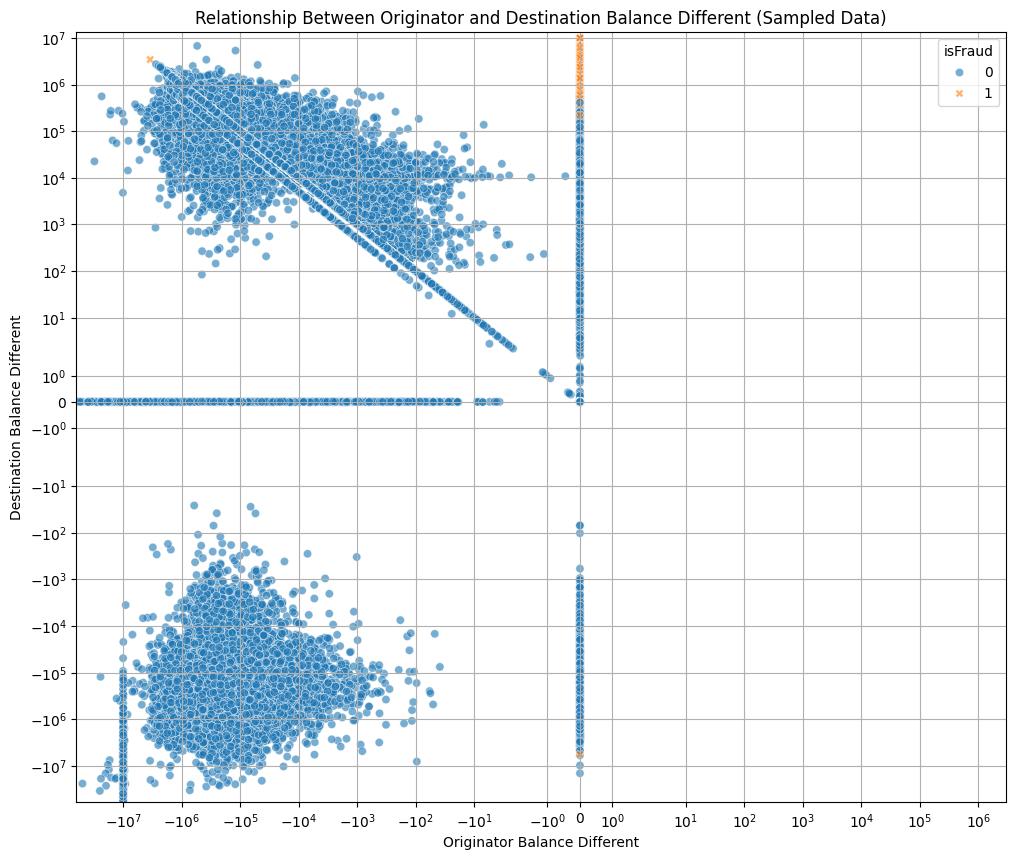

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df.sample(frac=0.1), x='errorBalanceOrig', y='errorBalanceDest',
                hue='isFraud', style='isFraud', alpha=0.6)
plt.title('Relationship Between Originator and Destination Balance Different (Sampled Data)')
plt.xlabel('Originator Balance Different')
plt.ylabel('Destination Balance Different')
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True)
plt.show()

In [ ]:
temp_ = df[(df['amount'] >= 1000000) & (df['oldbalanceOrg'] >= 1000000)]
print(f"Total Percentage of isFraud classification are",
      f"{temp_['isFraud'].sum() / len(temp_['isFraud']) *100}")

Total Percentage of isFraud classification are 89.38492063492063


**Observations:**

1. From a sampled dataset, it has been shown that fraud tends to occur . among wealthy customers.

2. From the balance differences, it is shown that withdrawals of amounts equal to or greater than $1,000,000 have a higher tendency to be fraudulent transactions.

**Decisions:**

6. Feature Engineering 2: Create a 'wealthy_customer' column to signify any large transaction that is equal to or exceeds $1,000,000.

In [ ]:
# Decision 6

df['wealthy_customer'] = np.nan

for i in df.index:
    if df.loc[i, 'amount'] >= 1000000 and df.loc[i,'oldbalanceOrg'] >= 1000000:
        df.loc[i, 'wealthy_customer'] = int(1)

df['wealthy_customer'] = df['wealthy_customer'].fillna(0)

In [ ]:
df = df.copy()


# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder


# Decision 1
encoder = OneHotEncoder(sparse_output=False)  # Return a dense array
encoded_data = encoder.fit_transform(df[['type']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['type']))

df = pd.concat([df, encoded_df], axis=1)

# Decision 2
df['nameDest'] = np.where(df['nameDest'].str.startswith('M'), 0,
                          np.where(df['nameDest'].str.startswith('C'), 1, -1)).astype(int)

# Decision 4 + All irrelevant columns
df = df.drop(columns=['isFlaggedFraud', 'overspill', 'oldbalanceOrg', 'step', 'type', 'nameOrig',
                      'errorBalanceOrig', 'errorBalanceDest',
                      'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

df['isFraud'] = df.pop('isFraud')

df.head(10)

,amount,nameDest,emptied,wealthy_customer,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,9839.64,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
1,1864.28,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
2,181.00,1,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1
3,181.00,1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1
4,11668.14,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
5,7817.71,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
6,7107.77,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
7,7861.64,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
8,4024.36,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0
9,5337.77,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0


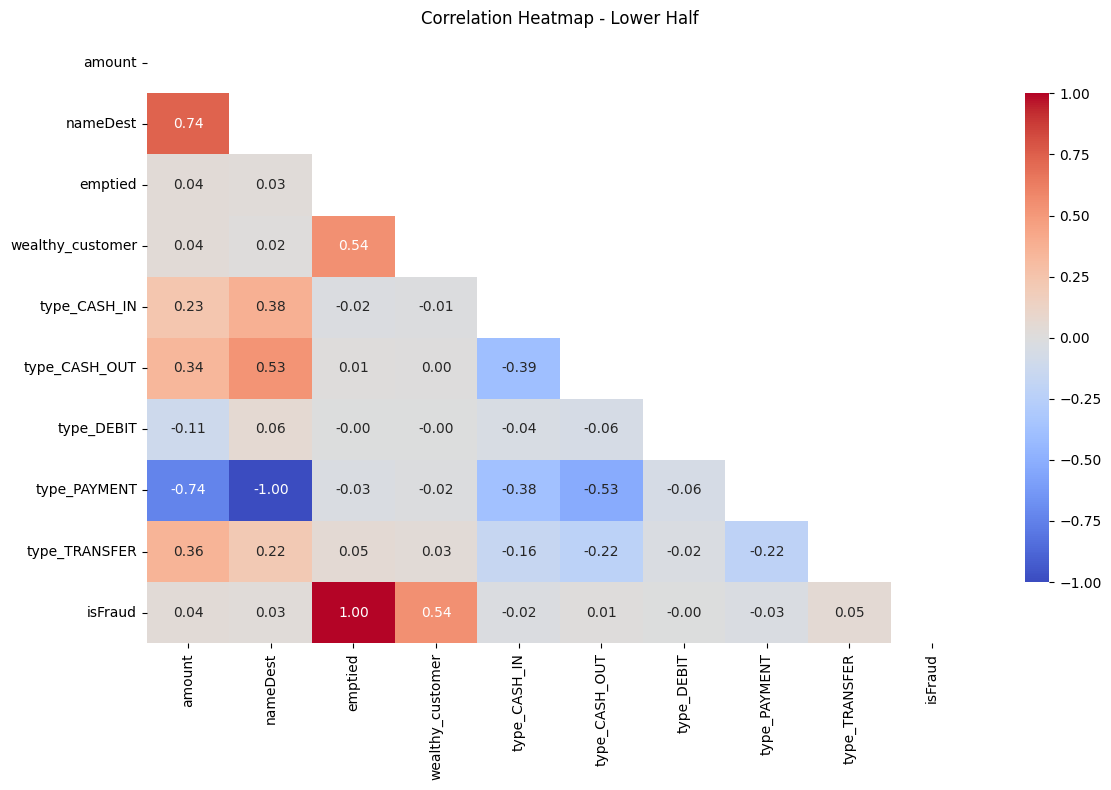

In [ ]:
corr = df.corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap - Lower Half')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['amount_scaled'] = scaler.fit_transform(df[['amount']])
df = df.drop(columns=['amount'], axis=1)

df['isFraud'] = df.pop('isFraud')
df

,nameDest,emptied,wealthy_customer,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_scaled,isFraud
0,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.28,0
1,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.29,0
2,1,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.30,1
3,1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,-0.30,1
4,0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.28,0
...,...,...,...,...,...,...,...,...,...,...
6362615,1,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.26,1
6362616,1,1.00,1.00,0.00,0.00,0.00,0.00,1.00,10.15,1
6362617,1,1.00,1.00,0.00,1.00,0.00,0.00,0.00,10.15,1
6362618,1,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.11,1
